In [1]:
import numpy as np
import dedalus.public as d3
import dedalus.core as d4
import logging
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib inline
import pathlib
import subprocess
import h5py
import glob

In [7]:
logger = logging.getLogger(__name__)


# Parameters
Lx, Lz = 4, 1
Nx, Nz = 256, 64
Md = 3
RayleighM = 1e6
RayleighD = 2.5e5
ratio=RayleighD/RayleighM
Vaisala= 1-ratio
Prandtl = 0.7
dealias = 3/2
stop_sim_time = 1
timestepper = d3.RK222
max_timestep = 0.125
dtype = np.float64

# Bases
coords = d3.CartesianCoordinates('x', 'z')
dist = d3.Distributor(coords, dtype=dtype)
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=dealias)
zbasis = d3.ChebyshevT(coords['z'], size=Nz, bounds=(0, Lz), dealias=dealias)

# Fields
p = dist.Field(name='p', bases=(xbasis,zbasis))
d = dist.Field(name='d', bases=(xbasis,zbasis))
m = dist.Field(name='m', bases=(xbasis,zbasis))
u = dist.VectorField(coords, name='u', bases=(xbasis,zbasis))
tau_p = dist.Field(name='tau_p')
tau_d1 = dist.Field(name='tau_d1', bases=xbasis)
tau_d2 = dist.Field(name='tau_d2', bases=xbasis)
tau_m1 = dist.Field(name='tau_m1', bases=xbasis)
tau_m2 = dist.Field(name='tau_m2', bases=xbasis)
tau_u1 = dist.VectorField(coords, name='tau_u1', bases=xbasis)
tau_u2 = dist.VectorField(coords, name='tau_u2', bases=xbasis)
tau_c1 = dist.Field(name='tau_c1', bases=xbasis)
tau_c2 = dist.Field(name='tau_c2', bases=xbasis)

# Substitutions
kappa = (RayleighM * Prandtl)**(-1/2)
nu = (RayleighM / Prandtl)**(-1/2)
x, z = dist.local_grids(xbasis, zbasis)
ex, ez = coords.unit_vector_fields(dist)
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)
grad_u = d3.grad(u) + ez*lift(tau_u1) # First-order reduction
grad_d = d3.grad(d) + ez*lift(tau_d1) # First-order reduction
grad_m = d3.grad(m) + ez*lift(tau_m1) # First-order reduction
ncc = dist.Field(name='ncc', bases=zbasis)
ncc['g'] = z
ncc.change_scales(3/2)
B = (m+d-Vaisala*ncc+np.absolute(m-d+Vaisala*ncc))/2
u_x = u @ ex
u_z = u @ ez
dz = lambda A: d3.Differentiate(A, coords['z'])
integ = lambda A: d3.Integrate(A, coords)
integ1= lambda A: d3.Integrate(A, coords)

# Problem
# First-order form: "div(f)" becomes "trace(grad_f)"
# First-order form: "lap(f)" becomes "div(grad_f)"
problem = d3.IVP([p, d, m, u, tau_p, tau_d1, tau_d2, tau_m1, tau_m2, tau_u1, tau_u2], namespace=locals())
problem.add_equation("trace(grad_u) + tau_p = 0")
problem.add_equation("dt(d) - kappa*div(grad_d) + lift(tau_d2) = - u@grad(d) + ncc -ncc")
problem.add_equation("dt(m) - kappa*div(grad_m) + lift(tau_m2) = - u@grad(m)")
problem.add_equation("dt(u) - nu*div(grad_u) + grad(p) + lift(tau_u2) = - u@grad(u)+ B*ez ")
problem.add_equation("d(z=0) = 1")
problem.add_equation("m(z=0) = 1")
problem.add_equation("d(z=Lz) = 1-ratio")
problem.add_equation("m(z=Lz) = 0")
problem.add_equation("u_z(z=0) = 0")
problem.add_equation("u_z(z=Lz) = 0")
problem.add_equation("dz(u_x)(z=0) = 0")
problem.add_equation("dz(u_x)(z=Lz)= 0")
problem.add_equation("integ(p) = 0") # Pressure gauge

# Solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

# Initial conditions
d.fill_random('g', seed=22, distribution='normal', scale=1e-3) # Random noise
d['g'] *= z * (Lz - z) # Damp noise at walls
d['g'] += Lz - z # Add linear background
m.fill_random('g', seed=39, distribution='normal', scale=1e-3) # Random noise
m['g'] *= z * (Lz - z) # Damp noise at walls
m['g'] += Lz - z # Add linear background

# Analysis
snapshotsM = solver.evaluator.add_file_handler('snapshotsM', sim_dt=0.25, max_writes=50)
snapshotsM.add_task(d, name='dry buoyancy')
snapshotsM.add_task(m, name='moist buoyancy')
snapshotsM.add_task(B, name='buoyancy')
snapshotsM.add_task(-d3.div(d3.skew(u)), name='vorticity')
snapshotsM.add_task(0.5*d3.dot(u,u), name='KE')
snapshotsM.add_task(integ1(0.5*d3.dot(u,u)), name='total KE')

# CFL
CFL = d3.CFL(solver, initial_dt=max_timestep, cadence=10, safety=0.5, threshold=0.05,
             max_change=1.5, min_change=0.5, max_dt=max_timestep)
CFL.add_velocity(u)

# Flow properties
flow = d3.GlobalFlowProperty(solver, cadence=10)
flow.add_property(np.sqrt(u@u)/nu, name='Re')

# Main loop
startup_iter = 10
try:
    logger.info('Starting main loop')
    while solver.proceed:
        timestep = CFL.compute_timestep()
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            max_Re = flow.max('Re')
            #logger.info('Iteration=%i, Time=%e, dt=%e, max(Re)=%f' %(solver.iteration, solver.sim_time, timestep, max_Re))
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()



2023-06-14 17:01:33,745 subsystems 0/1 INFO :: Building subproblem matrices 1/128 (~1%) Elapsed: 0s, Remaining: 19s, Rate: 6.7e+00/s
2023-06-14 17:01:34,679 subsystems 0/1 INFO :: Building subproblem matrices 13/128 (~10%) Elapsed: 1s, Remaining: 10s, Rate: 1.2e+01/s
2023-06-14 17:01:35,681 subsystems 0/1 INFO :: Building subproblem matrices 26/128 (~20%) Elapsed: 2s, Remaining: 8s, Rate: 1.2e+01/s
2023-06-14 17:01:36,691 subsystems 0/1 INFO :: Building subproblem matrices 39/128 (~30%) Elapsed: 3s, Remaining: 7s, Rate: 1.3e+01/s
2023-06-14 17:01:37,698 subsystems 0/1 INFO :: Building subproblem matrices 52/128 (~41%) Elapsed: 4s, Remaining: 6s, Rate: 1.3e+01/s
2023-06-14 17:01:38,695 subsystems 0/1 INFO :: Building subproblem matrices 65/128 (~51%) Elapsed: 5s, Remaining: 5s, Rate: 1.3e+01/s
2023-06-14 17:01:39,688 subsystems 0/1 INFO :: Building subproblem matrices 78/128 (~61%) Elapsed: 6s, Remaining: 4s, Rate: 1.3e+01/s
2023-06-14 17:01:40,956 subsystems 0/1 INFO :: Building subpro

In [13]:
logger = logging.getLogger(__name__)


# Parameters
Lx, Lz = 4, 1
Nx, Nz = 256, 64
Rayleigh = (RayleighD+RayleighM)/2
Prandtl = 1
dealias = 3/2
stop_sim_time = 1
timestepper = d3.RK222
max_timestep = 0.125
dtype = np.float64

# Fields
p = dist.Field(name='p', bases=(xbasis,zbasis))
d = dist.Field(name='d', bases=(xbasis,zbasis))
m = dist.Field(name='m', bases=(xbasis,zbasis))
b = dist.Field(name='b', bases=(xbasis,zbasis))
u = dist.VectorField(coords, name='u', bases=(xbasis,zbasis))
tau_p = dist.Field(name='tau_p')
tau_b1 = dist.Field(name='tau_b1', bases=xbasis)
tau_b2 = dist.Field(name='tau_b2', bases=xbasis)
tau_u1 = dist.VectorField(coords, name='tau_u1', bases=xbasis)
tau_u2 = dist.VectorField(coords, name='tau_u2', bases=xbasis)

# Substitutions
kappa = (Rayleigh * Prandtl)**(-1/2)
nu = (Rayleigh / Prandtl)**(-1/2)
x, z = dist.local_grids(xbasis, zbasis)
ex, ez = coords.unit_vector_fields(dist)
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)
grad_u = d3.grad(u) + ez*lift(tau_u1) # First-order reduction
grad_b = d3.grad(b) + ez*lift(tau_b1) # First-order reduction
integ = lambda A: d3.Integrate(A, coords)
integ1= lambda A: d3.Integrate(A, coords)

# Problem
# First-order form: "div(f)" becomes "trace(grad_f)"
# First-order form: "lap(f)" becomes "div(grad_f)"
problem = d3.IVP([p, b, u, tau_p, tau_b1, tau_b2, tau_u1, tau_u2], namespace=locals())
problem.add_equation("trace(grad_u) + tau_p = 0")
problem.add_equation("dt(b) - kappa*div(grad_b) + lift(tau_b2) = - u@grad(b)")
problem.add_equation("dt(u) - nu*div(grad_u) + grad(p) - b*ez + lift(tau_u2) = - u@grad(u)")
problem.add_equation("b(z=0) = 1")
problem.add_equation("u(z=0) = 0")
problem.add_equation("b(z=Lz) = 0")
problem.add_equation("u(z=Lz) = 0")
problem.add_equation("integ(p) = 0") # Pressure gauge

# Solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

# Initial conditions
d.fill_random('g', seed=22, distribution='normal', scale=1e-3) # Random noise
d['g'] *= z * (Lz - z) # Damp noise at walls
d['g'] += Lz - z # Add linear background

m.fill_random('g', seed=39, distribution='normal', scale=1e-3) # Random noise
m['g'] *= z * (Lz - z) # Damp noise at walls
m['g'] += Lz - z # Add linear background

b['g'] = np.maximum(d['g']-Vaisala*z,m['g']) # Add linear background

# Analysis
snapshotsD = solver.evaluator.add_file_handler('snapshotsD', sim_dt=0.25, max_writes=50)
snapshotsD.add_task(b, name='buoyancy')
snapshotsD.add_task(-d3.div(d3.skew(u)), name='vorticity')
snapshotsD.add_task(integ1(0.5*d3.dot(u,u)), name='KE')

# CFL
CFL = d3.CFL(solver, initial_dt=max_timestep, cadence=10, safety=0.5, threshold=0.05,
             max_change=1.5, min_change=0.5, max_dt=max_timestep)
CFL.add_velocity(u)

# Flow properties
flow = d3.GlobalFlowProperty(solver, cadence=10)
flow.add_property(np.sqrt(u@u)/nu, name='Re')

# Main loop
startup_iter = 10
try:
    logger.info('Starting main loop')
    while solver.proceed:
        timestep = CFL.compute_timestep()
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            max_Re = flow.max('Re')
            #logger.info('Iteration=%i, Time=%e, dt=%e, max(Re)=%f' %(solver.iteration, solver.sim_time, timestep, max_Re))
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()


2023-06-14 17:02:59,825 subsystems 0/1 INFO :: Building subproblem matrices 1/128 (~1%) Elapsed: 0s, Remaining: 6s, Rate: 2.0e+01/s
2023-06-14 17:03:00,430 subsystems 0/1 INFO :: Building subproblem matrices 13/128 (~10%) Elapsed: 1s, Remaining: 6s, Rate: 2.0e+01/s
2023-06-14 17:03:01,097 subsystems 0/1 INFO :: Building subproblem matrices 26/128 (~20%) Elapsed: 1s, Remaining: 5s, Rate: 2.0e+01/s
2023-06-14 17:03:01,750 subsystems 0/1 INFO :: Building subproblem matrices 39/128 (~30%) Elapsed: 2s, Remaining: 5s, Rate: 2.0e+01/s
2023-06-14 17:03:02,403 subsystems 0/1 INFO :: Building subproblem matrices 52/128 (~41%) Elapsed: 3s, Remaining: 4s, Rate: 2.0e+01/s
2023-06-14 17:03:03,055 subsystems 0/1 INFO :: Building subproblem matrices 65/128 (~51%) Elapsed: 3s, Remaining: 3s, Rate: 2.0e+01/s
2023-06-14 17:03:03,718 subsystems 0/1 INFO :: Building subproblem matrices 78/128 (~61%) Elapsed: 4s, Remaining: 3s, Rate: 2.0e+01/s
2023-06-14 17:03:04,377 subsystems 0/1 INFO :: Building subprobl

In [31]:
print(subprocess.check_output("find snapshotsM | sort", shell=True).decode())
print(subprocess.check_output("find snapshotsD | sort", shell=True).decode())

snapshotsM
snapshotsM/snapshotsM_s1.h5

snapshotsD
snapshotsD/snapshotsD_s1.h5



Text(0, 0.5, 'KE')

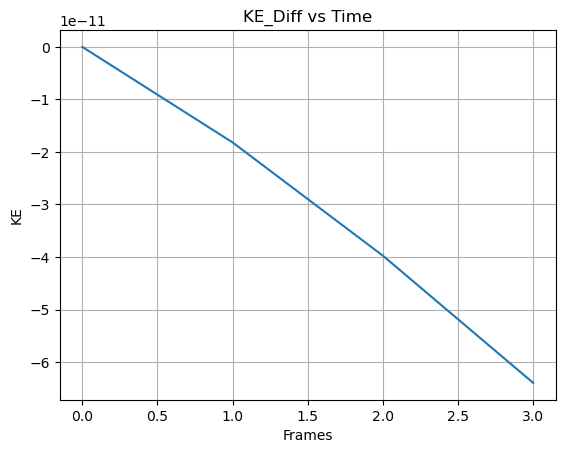

In [30]:
files = sorted(glob.glob('snapshotsM/*.h5'))

with h5py.File(files[0], mode='r') as file:
    KEsM = file['tasks']['total KE'][:,:,:]
    
for i in range(1,len(files)):
    with h5py.File(files[i], mode='r') as file:
        KEM = file['tasks']['total KE'][:,:,:]
        KEsM=np.append(KEsM,KEM,axis=0)

files = sorted(glob.glob('snapshotsD/*.h5'))
with h5py.File(files[0], mode='r') as file:
    KEsD = file['tasks']['KE'][:,:,:]
    
for i in range(1,len(files)):
    with h5py.File(files[i], mode='r') as file:
        KED = file['tasks']['KE'][:,:,:]
        KEsD=np.append(KEsD,KED,axis=0)

KE_diff=KEsD-KEsM
fig, ax = plt.subplots()
ax.plot(np.arange(len(KE_diff[:,0,0])), KE_diff[:,0,0])

ax.set_title('KE_Diff vs Time')
ax.grid(True)
ax.set_xlabel('Frames')
ax.set_ylabel('KE')


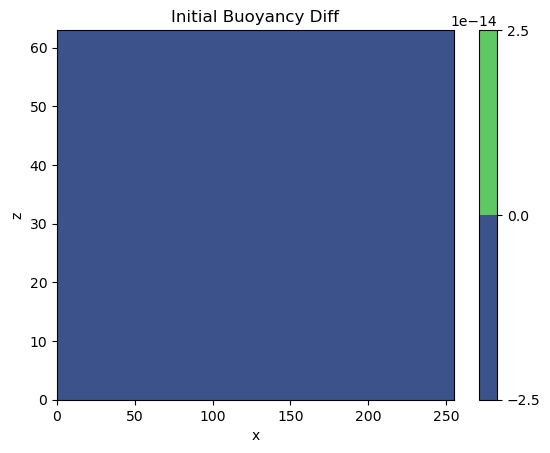

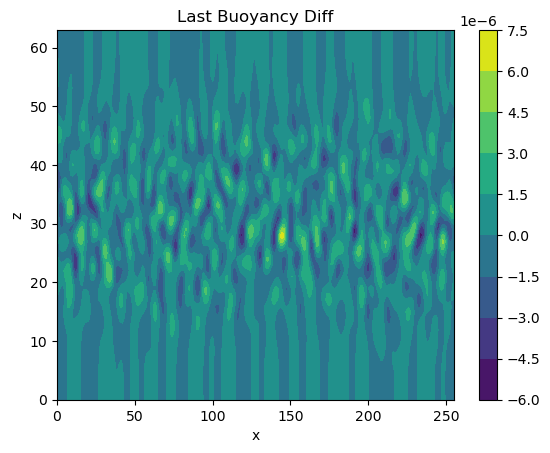

In [24]:
with h5py.File('snapshotsM/snapshotsM_s1.h5', 'r') as file:
    moist_buoyancy = file['tasks']['moist buoyancy'][:, :, :] 
    dry_buoyancy = file['tasks']['dry buoyancy'][:, :, :]
    buoyancyM = np.maximum(moist_buoyancy,dry_buoyancy-Vaisala*z)

with h5py.File('snapshotsD/snapshotsD_s1.h5', 'r') as file:
    buoyancyD = file['tasks']['buoyancy'][:, :, :] 

buoyancy_diff=buoyancyD-buoyancyM
    
# Plotting moist buoyancy
plt.figure()
plt.contourf(np.arange(len(buoyancy_diff[-1, :, 1])), np.arange(len(buoyancy_diff[0, 0, :])), buoyancy_diff[0,:,:].T)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('z')
plt.title('Initial Buoyancy Diff')

# Plotting moist buoyancy
plt.figure()
plt.contourf(np.arange(len(buoyancy_diff[-1, :, 1])), np.arange(len(buoyancy_diff[0, 0, :])), buoyancy_diff[-1,:,:].T)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('z')
plt.title('Last Buoyancy Diff')
plt.show()

2023-06-14 17:19:05,780 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.ImageMagickWriter'>
2023-06-14 17:19:05,783 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: convert -size 640x480 -depth 8 -delay 10.0 -loop 0 rgba:- -layers OptimizePlus buoyancy_diff.gif


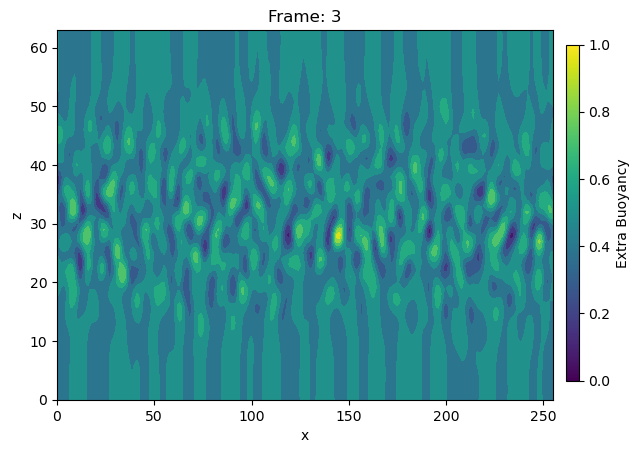

In [33]:
with h5py.File('snapshotsM/snapshotsM_s1.h5', 'r') as file:
    moist_buoyancy = file['tasks']['moist buoyancy'][:, :, :] 
    dry_buoyancy = file['tasks']['dry buoyancy'][:, :, :]
    buoyancyM = np.maximum(moist_buoyancy,dry_buoyancy-Vaisala*z)

with h5py.File('snapshotsD/snapshotsD_s1.h5', 'r') as file:
    buoyancyD = file['tasks']['buoyancy'][:, :, :] 

buoyancy_diff=buoyancyD-buoyancyM
        
fig, ax = plt.subplots()
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Define colorbar axes position

def animate(frame):
    ax.clear()
    ax.contourf(buoyancy_diff[frame, :, : ].T)
    ax.set_title('Frame: {}'.format(frame))
    ax.set_xlabel('x')  # Add x-axis label
    ax.set_ylabel('z')  # Add y-axis label
    vmin = np.min(buoyancy_diff[frame, :, :])
    vmax = np.max(buoyancy_diff[frame, :, :])
    cb = plt.colorbar(ax.collections[0], cax=cax)
    cb.set_label('Extra Buoyancy')

# Call animate method
animation = FuncAnimation(fig, animate, frames=len(buoyancy_diff), interval=100, blit=False)
animation.save('buoyancy_diff.gif', writer='imagemagick')
# Display the plot
plt.show()